### Multi-Class Text Classification with SKlearn and NLTK in python

<b>Problem statement:</b> to understand the type of work that is carried out by the software developers.

Based on the number of classes, we could have a binary classifier or a multi-class classifier. But in both the cases the steps to build up the classifier are more or less the same:

1. Text preprocessing, including text cleanup and text normalization
2. Vector Representation / Feature Extraction - Bag of words
3. Building a model for classification
4. Evaluating the classifier with precision and recall
5. Applying the model to a query to get the predicted label

In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sqlite3 import Error
from sklearn.ensemble import RandomForestClassifier
import sqlite3
import pickle
import nltk
nltk.download('stopwords')
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bhairab.singh.soren\AppData\Roaming\nltk_data
[nltk_data]     ...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
try:
    conn = sqlite3.connect("training_V2.db")
except Error as e:
    print(e)

In [5]:
#reading the data from the table that contains the labels	
df = pd.read_sql_query('SELECT * FROM filtered', conn)
df.drop(['id'], 1, inplace=True)
df.head()

text  class
0  MAHOUT-1045: committing patch with changes to ...      5
1  Add notes for coptic bug fix and scalar perfor...      5
2  cloudStack 3.0 new UI - NaaS - fix a bug that ...      1
3  add logic to handle all 2xx response code, bug...      1
4  Fixed adding route for additional public nic o...      1

In [16]:
df['text'][345]

'Add query validation feature'

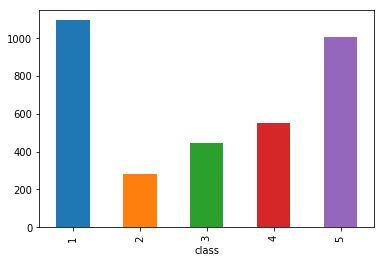

In [6]:
df.groupby('class').text.count().plot.bar(ylim=0)
plt.show()

1 represents commit messages <b>for bug fixing.</b><br>
2 represents commits <b>that belong to no category.</b><br>
3 represents commit messages <b>for design improvement.</b><br>
4 represents commit messages for <b>adding new features.</b><br>
5 represents commit messages for <b>improving non-functional requirements.</b><br>

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3377 entries, 0 to 3376
Data columns (total 2 columns):
text     3377 non-null object
class    3377 non-null int64
dtypes: int64(1), object(1)
memory usage: 52.8+ KB


In [8]:
nltk.download('stopwords')
stemmer = PorterStemmer()
words = stopwords.words("english")
df['cleaned'] = df['text'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bhairab.singh.soren\AppData\Roaming\nltk_data
[nltk_data]     ...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
df.head()

text  class  \
0  MAHOUT-1045: committing patch with changes to ...      5   
1  Add notes for coptic bug fix and scalar perfor...      5   
2  cloudStack 3.0 new UI - NaaS - fix a bug that ...      1   
3  add logic to handle all 2xx response code, bug...      1   
4  Fixed adding route for additional public nic o...      1   

                                             cleaned  
0  mahout commit patch chang unit test cdbw numbe...  
1      add note coptic bug fix scalar perform improv  
2  cloudstack new ui naa fix bug dedic paramet di...  
3  add logic handl xx respons code bug fix string...  
4                  fix ad rout addit public nic fail

In [10]:
vectorizer = TfidfVectorizer(min_df= 3, stop_words="english", sublinear_tf=True, norm='l2', ngram_range=(1, 2))
final_features = vectorizer.fit_transform(df['cleaned']).toarray()
final_features.shape

(3377, 2389)

In [11]:
# this block is to split the dataset into training and testing set 
X = df['cleaned']
Y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

In [12]:
# instead of doing these steps one at a time, we can use a pipeline to complete then all at once
pipeline = Pipeline([('vect', vectorizer),
                     ('chi',  SelectKBest(chi2, k=1200)),
                     ('clf', RandomForestClassifier())])

In [13]:
# fitting our model and save it in a pickle for later use
model = pipeline.fit(X_train, y_train)
with open('RandomForest.pickle', 'wb') as f:
    pickle.dump(model, f)

ytest = np.array(y_test)

In [14]:
# confusion matrix and classification report(precision, recall, F1-score)
print(classification_report(ytest, model.predict(X_test)))
print(confusion_matrix(ytest, model.predict(X_test)))

             precision    recall  f1-score   support

          1       0.99      1.00      0.99       287
          2       0.94      0.95      0.94        79
          3       0.98      0.96      0.97       113
          4       1.00      0.96      0.98       134
          5       0.98      1.00      0.99       232

avg / total       0.98      0.98      0.98       845

[[286   1   0   0   0]
 [  3  75   0   0   1]
 [  0   1 109   0   3]
 [  1   3   2 128   0]
 [  0   0   0   0 232]]
